In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import langevin
import lmfit as lm

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# here we define the values of the physical parameters
# all energies are in kT = 4e-21J and lengths are in micrometers
# kappa = 10kT, sigma = 0.5 microJ/m^2, gamma = 0.1MJ/m^4, eta = 1.0mPa s
kappa = 10
sigma = 125
ga = 25
eta= 0.25
qmin=np.sqrt(3)/10

In [3]:
# Here we describe the system in a continuous way

In [4]:
def gamma(q, kappa=kappa, sigma=sigma, ga=ga, eta=eta ):
    return (kappa*q**4+sigma*q**2+ga)/(4*eta*q)

In [5]:
def avg(q,resolution):
    return (np.exp(-gamma(q)*resolution)-1.0+gamma(q)*resolution)/(gamma(q)**2*resolution**2)

In [6]:
def integrant(q,t):
    return q*np.exp(-gamma(q)*t)/(kappa*q**4+sigma*q**2+ga)*avg(q,1e-6)*np.exp(-0.25*0.5**2*q**2)

In [7]:
time=np.logspace(-5,0,50)

In [8]:
acf=[quad(integrant,qmin,np.inf,args=(t))[0] for t in time]

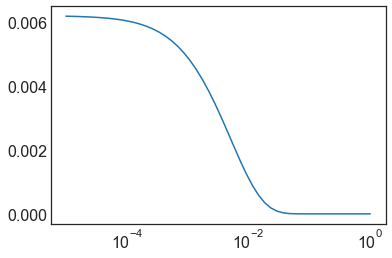

In [9]:
plt.semilogx(time,acf)

lets try the discrete one.  Here we assume that we have a $q_{min}$ and that $q^2=q_{x}^2+q_{y}^2$ where each $q_{x}=lq_{min}$ and $q_{y}=mq_{min}$ which results in $q_{lm}=q_{min}\sqrt{l^2+m^2}$

In [10]:
q_list=[np.sqrt(l**2+m**2) for l in range(0,3) for m in range(0,3)]

In [11]:
q_list=np.array(sorted(q_list)[1:])
print(q_list.size)
print(q_list)
q_list=q_list*qmin

8
[1.         1.         1.41421356 2.         2.         2.23606798
 2.23606798 2.82842712]


In [12]:
def corrfct(t,q_list):
    corr=np.exp(-gamma(q_list)*t)/(kappa*q_list**4+sigma*q_list**2+ga)*avg(q_list,1e-6)*np.exp(-0.25*0.5**2*q_list**2)
    return corr.sum()

In [13]:
acf_d = np.array([corrfct(t,q_list) for t in time])

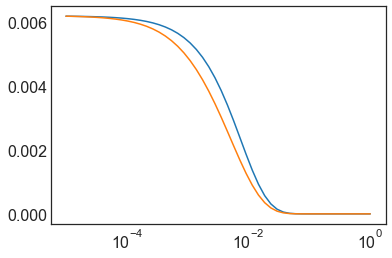

In [14]:
# plot correlation functions and normalize them to the same msd
plt.semilogx(time,acf_d*acf[0]/acf_d[0])
plt.semilogx(time,acf)

In [15]:
delta_t = 0.00001
def simulate_membrane(N):
    ts_all = None
    for q in q_list:
        ts = langevin.time_series2(1/(kappa*q**4+sigma*q**2+ga),gamma(q),delta_t,N)
    #    print(1/(kappa*q**4+sigma*q**2+ga),gamma(q))
        if ts_all is None:
            ts_all = ts
        else:
            ts_all = ts_all + ts
    return ts_all

ts_all=simulate_membrane(100000)

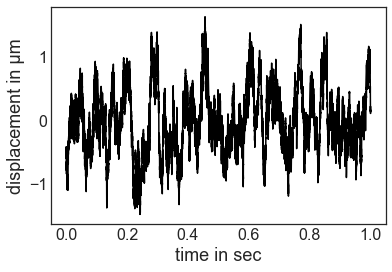

In [16]:
plt.plot(np.arange(ts_all.size)*delta_t,ts_all,"k")
plt.xlabel("time in sec")
plt.ylabel("displacement in µm")
plt.savefig("membrane_ts300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

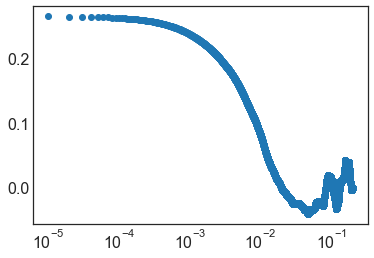

In [17]:
N = ts_all.size
# calculate autocorrelation function
f = np.fft.rfft(ts_all)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / N
autocorr = acf[int(N / 2):]

autocorr = autocorr[:20000]
t = np.arange(autocorr.size)*delta_t
plt.semilogx(t, autocorr,"o")

In [18]:
def fitcorr(t,kappa,sigma,ga,eta):
    corr=[np.sum(np.exp(-gamma(q_list,kappa=kappa, sigma=sigma, ga=ga, eta=eta)*tt)/(kappa*q_list**4+sigma*q_list**2+ga)) for tt in t]
    return corr

fit_corr_model=lm.Model(fitcorr)

[[Model]]
    Model(fitcorr)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 20000
    # variables        = 1
    chi-square         = 13.0893610
    reduced chi-square = 6.5450e-04
    Akaike info crit   = -146631.756
    Bayesian info crit = -146623.852
[[Variables]]
    kappa:  10 (fixed)
    sigma:  125 (fixed)
    ga:     25 (fixed)
    eta:    0.27417142 +/- 0.00229336 (0.84%) (init = 0.25)


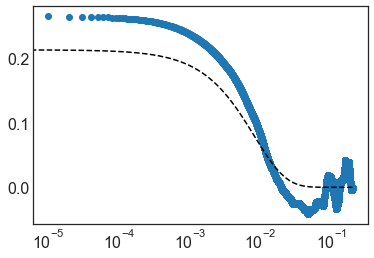

In [19]:
paramsFC = fit_corr_model.make_params()
paramsFC['kappa'].set(value=kappa,vary=False)
paramsFC['sigma'].set(value=sigma,vary=False)
paramsFC['ga'].set(value=ga,vary=False)
paramsFC['eta'].set(value=eta,vary=True)

resultFC = fit_corr_model.fit(t=t,data=autocorr,params=paramsFC)

plt.figure()
plt.semilogx(t,autocorr,"o")
plt.semilogx(t,resultFC.best_fit, 'k--')

print(resultFC.fit_report(min_correl=0.25))

In [20]:
gamma_list = []
gamma_std_list = []
N = 100000
for i in range(100):
    ts=simulate_membrane(N)
    # calculate autocorrelation function
    f = np.fft.rfft(ts)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]
    
    autocorr = autocorr[:20000]
    t = np.arange(autocorr.size)*delta_t

    # fit the autocorrelation function
    paramsFC = fit_corr_model.make_params()
    paramsFC['kappa'].set(value=kappa,vary=False)
    paramsFC['sigma'].set(value=sigma,vary=False)
    paramsFC['ga'].set(value=ga,vary=True)
    paramsFC['eta'].set(value=eta,vary=False)

    resultFC = fit_corr_model.fit(t=t,data=autocorr,params=paramsFC)

    gamma_list.append(np.abs(resultFC.values['ga']))
    gamma_std_list.append(resultFC.covar[0][0])
    print("done with..",i)
    
gamma_list = np.array(gamma_list)
gamma_std_list = np.array(gamma_std_list)

done with.. 0
done with.. 1
done with.. 2
done with.. 3
done with.. 4
done with.. 5
done with.. 6
done with.. 7
done with.. 8
done with.. 9
done with.. 10
done with.. 11
done with.. 12
done with.. 13
done with.. 14
done with.. 15
done with.. 16
done with.. 17
done with.. 18
done with.. 19
done with.. 20
done with.. 21
done with.. 22
done with.. 23
done with.. 24
done with.. 25
done with.. 26
done with.. 27
done with.. 28
done with.. 29
done with.. 30
done with.. 31
done with.. 32
done with.. 33
done with.. 34
done with.. 35
done with.. 36
done with.. 37
done with.. 38
done with.. 39
done with.. 40
done with.. 41
done with.. 42
done with.. 43
done with.. 44
done with.. 45
done with.. 46
done with.. 47
done with.. 48
done with.. 49
done with.. 50
done with.. 51
done with.. 52
done with.. 53
done with.. 54
done with.. 55
done with.. 56
done with.. 57
done with.. 58
done with.. 59
done with.. 60
done with.. 61
done with.. 62
done with.. 63
done with.. 64
done with.. 65
done with.. 66
done 

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


(0.03, 0.18)

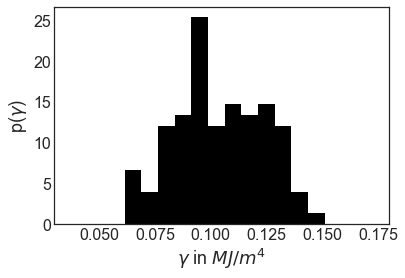

In [21]:
plt.hist(gamma_list*4/1000, bins=12,color="k",normed=True)
plt.ylabel(r"p($\gamma$)")
plt.xlabel(r"$\gamma$ in $MJ/m^{4}$")
plt.xlim((0.03,0.18))
#plt.savefig("membrane_gamma300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [22]:
print(gamma_std_list.mean(),gamma_list.std(),gamma_list.mean())

0.01072736905533967 4.98264007400951 26.027704926927523


In [23]:
print(4*gamma_std_list.mean(),4*gamma_list.std(),4*gamma_list.mean())

0.04290947622135868 19.93056029603804 104.11081970771009


In [24]:
print(gamma_list.std()/gamma_std_list.mean())

464.479225829314


In [25]:
print(0.024/6e-5)

400.0


In [26]:
acf_all=None
N = 100000
for i in range(100):
    print("simulated ",i)
    ts=simulate_membrane(N)
    # calculate autocorrelation function
    f = np.fft.rfft(ts)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]
    
    autocorr = autocorr[:20000]
    t = np.arange(autocorr.size)*delta_t
    
    if acf_all is None:
        acf_all = autocorr
    else:
        acf_all = np.vstack((acf_all, autocorr))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

simulated  0
simulated  1
simulated  2
simulated  3
simulated  4
simulated  5
simulated  6
simulated  7
simulated  8
simulated  9
simulated  10
simulated  11
simulated  12
simulated  13
simulated  14
simulated  15
simulated  16
simulated  17
simulated  18
simulated  19
simulated  20
simulated  21
simulated  22
simulated  23
simulated  24
simulated  25
simulated  26
simulated  27
simulated  28
simulated  29
simulated  30
simulated  31
simulated  32
simulated  33
simulated  34
simulated  35
simulated  36
simulated  37
simulated  38
simulated  39
simulated  40
simulated  41
simulated  42
simulated  43
simulated  44
simulated  45
simulated  46
simulated  47
simulated  48
simulated  49
simulated  50
simulated  51
simulated  52
simulated  53
simulated  54
simulated  55
simulated  56
simulated  57
simulated  58
simulated  59
simulated  60
simulated  61
simulated  62
simulated  63
simulated  64
simulated  65
simulated  66
simulated  67
simulated  68
simulated  69
simulated  70
simulated  71
si

<ErrorbarContainer object of 3 artists>

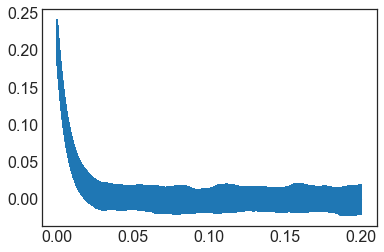

In [31]:
plt.errorbar(t,acf_mean,yerr=acf_std)

In [27]:
g_list=[]
dg_list=[]

gS_list=[]
dgS_list=[]

def residual(pars, x, data=None, eps=None):
    # unpack parameters: extract .value attribute for each parameter
    parvals = pars.valuesdict()
    ga = parvals['ga']
    kappa = parvals['kappa']
    sigma = parvals['sigma']
    eta = parvals['eta']

    model = fitcorr(x,kappa,sigma,ga,eta)

    if data is None:
        return model
    if eps is None:
        return model - data
    return (model-data) / eps

for y in acf_all:
    pars = lm.Parameters()
    pars.add('kappa', value=kappa, vary=False)
    pars.add('sigma', value=sigma, vary=False)
    pars.add('ga', value=ga, vary=True)
    pars.add('eta', value=eta, vary=False)
 
    result = lm.minimize(residual, pars,kws = {'x':t,'data':y,'eps':acf_std})
    #result.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))
    res = lm.minimize(residual, kws = {'x':t,'data':y,'eps':acf_std},method='emcee', nan_policy='omit', burn=300, steps=1000, thin=20,
                     params=result.params)

    print(lm.fit_report(result.params))
    g_list.append(result.params.valuesdict()['ga'])
    dg_list.append(np.sqrt(result.covar[0,0]))
    print(g_list[-1],dg_list[-1])

    gS_list.append(res.flatchain['ga'].mean())
    dgS_list.append(res.flatchain['ga'].mean())
    print(gS_list[-1],dgS_list[-1])
    


100%|██████████| 1000/1000 [10:34:30<00:00, 38.07s/it]


[[Variables]]
    kappa:  10 (fixed)
    sigma:  125 (fixed)
    ga:     28.9101353 +/- 0.13163437 (0.46%) (init = 25)
    eta:    0.25 (fixed)


NameError: name 'dg_list2' is not defined

In [28]:
gS_list.append(res.flatchain['ga'].mean())
dgS_list.append(res.flatchain['ga'].mean())

In [29]:
print(g_list[-1],dg_list[-1])

28.91013532789121 0.13163437031611613


In [30]:
print(gS_list[-1],dgS_list[-1])

28.916058902756763 28.916058902756763
